# Transit-Proximate Crime Analysis: Toronto TTC Stations

The goal is to identify spatial and temporal patterns of crime near transit stations, which can inform public safety strategies and resource allocation for transit police services for event like FIFA.

Key Questions:
- How do crime patterns vary by time of day, day of week, and year?
- Which TTC stations have the highest concentration of nearby crime?
- What proportion of crimes occur within walking distance (500m/1km) of transit stations?
- How do different crime types distribute across hours and locations?

Data Sources:
- Toronto Major Crime Indicators (Open Data)
- TTC Subway Line Shapefiles (WGS84 coordinates)
- TTC Station Ridership Data (optional for exposure analysis)

In [44]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport ## use for quick EDA report

# 0. Load & Clean Data

Toronto Major Crime Indicators dataset was loaded and perform initial data cleaning. 

- Converting date fields to datetime format for temporal analysis
- Remove records with missing coordinates or crime categories
- Filter Toronto's geographic boundaries lat: 43-44, lon: -79 to -80

In [45]:
crime = pd.read_csv('/Users/vicky_ceshen/Downloads/Major_Crime_Indicators_Open_Data_-3805566126367379926.csv')

In [46]:
profile = ProfileReport(crime, title="Profiling Report")

In [47]:
crime.head()

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84,x,y
0,1,GO-20141261013,1/1/2014 5:00:00 AM,1/1/2014 5:00:00 AM,2014,January,1,1,Wednesday,4,...,Assault,Assault,155,Downsview (155),026,Downsview-Roding-CFB (26),-79.483869,43.734369,-8.848104e+06,5.424427e+06
1,2,GO-20141261561,1/1/2014 5:00:00 AM,1/1/2014 5:00:00 AM,2014,January,1,1,Wednesday,8,...,Assault With Weapon,Assault,154,Oakdale-Beverley Heights (154),026,Downsview-Roding-CFB (26),-79.513772,43.719813,-8.851433e+06,5.422185e+06
2,3,GO-20141262377,1/1/2014 5:00:00 AM,1/1/2014 5:00:00 AM,2014,January,1,1,Wednesday,12,...,Assault Bodily Harm,Assault,068,North Riverdale (68),068,North Riverdale (68),-79.357562,43.674791,-8.834043e+06,5.415253e+06
3,4,GO-20141262553,1/1/2014 5:00:00 AM,1/1/2014 5:00:00 AM,2014,January,1,1,Wednesday,14,...,Assault,Assault,094,Wychwood (94),094,Wychwood (94),-79.422371,43.673842,-8.841258e+06,5.415106e+06
4,5,GO-20141263115,1/1/2014 5:00:00 AM,1/1/2014 5:00:00 AM,2014,January,1,1,Wednesday,16,...,Assault,Assault,120,Clairlea-Birchmount (120),120,Clairlea-Birchmount (120),-79.286725,43.700100,-8.826158e+06,5.419149e+06


In [48]:

# Parse dates
crime["OCC_DATE"] = pd.to_datetime(crime["OCC_DATE"])
crime["REPORT_DATE"] = pd.to_datetime(crime["REPORT_DATE"])


In [49]:

# Basic cleanup
crime = crime.dropna(subset=["LAT_WGS84","LONG_WGS84","MCI_CATEGORY"])
crime = crime[(crime["LAT_WGS84"] > 43) & (crime["LAT_WGS84"] < 44)]
crime = crime[(crime["LONG_WGS84"] < -79) & (crime["LONG_WGS84"] > -80)]

crime.head()

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84,x,y
0,1,GO-20141261013,2014-01-01 05:00:00,2014-01-01 05:00:00,2014,January,1,1,Wednesday,4,...,Assault,Assault,155,Downsview (155),026,Downsview-Roding-CFB (26),-79.483869,43.734369,-8.848104e+06,5.424427e+06
1,2,GO-20141261561,2014-01-01 05:00:00,2014-01-01 05:00:00,2014,January,1,1,Wednesday,8,...,Assault With Weapon,Assault,154,Oakdale-Beverley Heights (154),026,Downsview-Roding-CFB (26),-79.513772,43.719813,-8.851433e+06,5.422185e+06
2,3,GO-20141262377,2014-01-01 05:00:00,2014-01-01 05:00:00,2014,January,1,1,Wednesday,12,...,Assault Bodily Harm,Assault,068,North Riverdale (68),068,North Riverdale (68),-79.357562,43.674791,-8.834043e+06,5.415253e+06
3,4,GO-20141262553,2014-01-01 05:00:00,2014-01-01 05:00:00,2014,January,1,1,Wednesday,14,...,Assault,Assault,094,Wychwood (94),094,Wychwood (94),-79.422371,43.673842,-8.841258e+06,5.415106e+06
4,5,GO-20141263115,2014-01-01 05:00:00,2014-01-01 05:00:00,2014,January,1,1,Wednesday,16,...,Assault,Assault,120,Clairlea-Birchmount (120),120,Clairlea-Birchmount (120),-79.286725,43.700100,-8.826158e+06,5.419149e+06


# 1. Temporal EDA (Exploratory Data Analysis)

Understanding when crimes occur helps transit authorities allocate security resources effectively. We analyze three temporal dimensions:

**Yearly Trends:** Long-term patterns showing whether crime is increasing, decreasing, or stable over time.

**Hourly Patterns:** Identifies peak crime hours (e.g., late night, rush hour) to guide patrol scheduling.

**Day-of-Week Patterns:** Reveals whether weekends or weekdays have higher crime rates, potentially linked to commuter vs. leisure travel patterns.

<Axes: title={'center': 'Crime by Year'}, xlabel='REPORT_YEAR'>

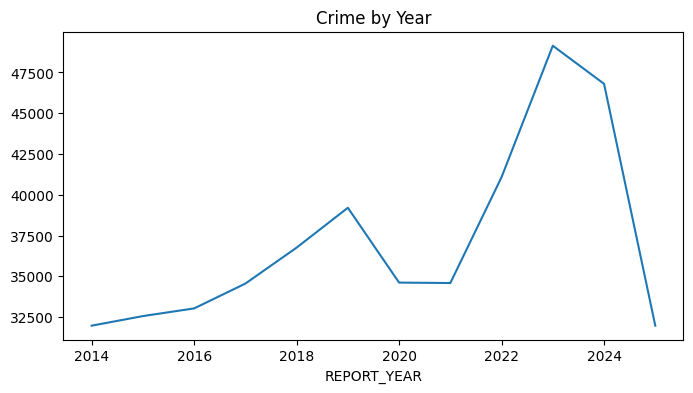

In [50]:
# Yearly Trend
crime.groupby("REPORT_YEAR").size().plot(kind="line", figsize=(8,4), title="Crime by Year")


<Axes: title={'center': 'Crime by Hour'}, xlabel='REPORT_HOUR'>

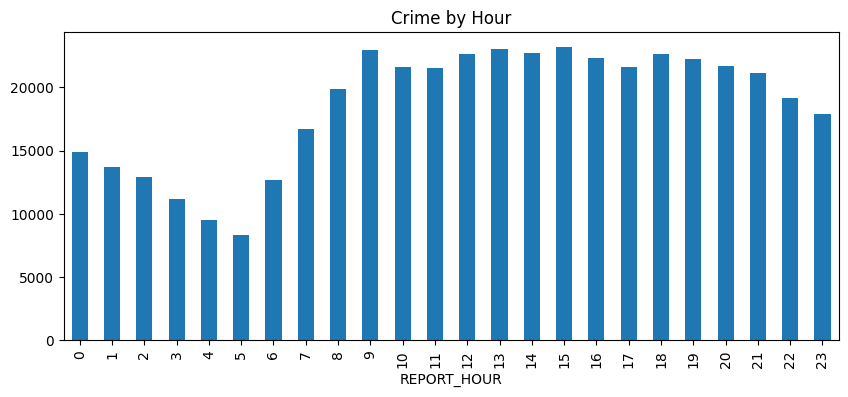

In [51]:
#Hourly 
crime.groupby("REPORT_HOUR").size().plot(kind="bar", figsize=(10,4), title="Crime by Hour")


<Axes: title={'center': 'Crime by Day of Week'}, xlabel='REPORT_DOW'>

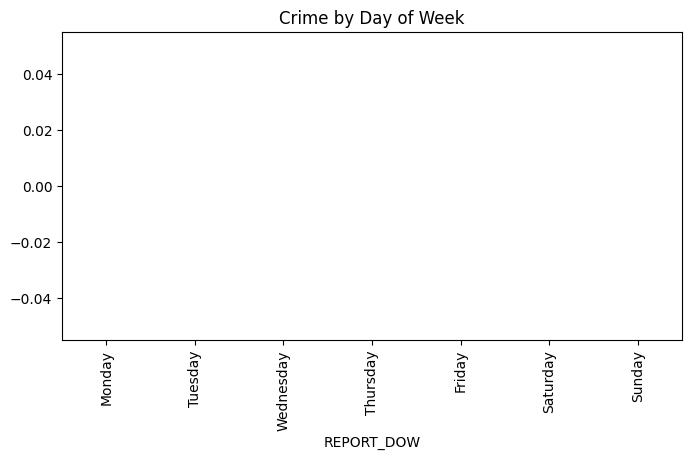

In [ ]:
# Weekday
crime.groupby("REPORT_DOW").size().reindex([
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
]).plot(kind="bar", figsize=(8,4), title="Crime by Day of Week")
plt.tight_layout()
plt.show()

### Extract TTC Station Locations from Subway Line Shapefile

Since we don't have a direct station point dataset, we'll extract station locations from the TTC subway line shapefile using a spatial clustering approach

In [ ]:
# %pip install geopandas shapely fiona pyproj -m pip install xyz



Usage:   
  /opt/homebrew/opt/python@3.13/bin/python3.13 -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/homebrew/opt/python@3.13/bin/python3.13 -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/homebrew/opt/python@3.13/bin/python3.13 -m pip install [options] [-e] <vcs project url> ...
  /opt/homebrew/opt/python@3.13/bin/python3.13 -m pip install [options] [-e] <local project path> ...
  /opt/homebrew/opt/python@3.13/bin/python3.13 -m pip install [options] <archive url/path> ...

no such option: -m
Note: you may need to restart the kernel to use updated packages.


In [54]:
# import sys
# import subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "--break-system-packages", "geopandas"])

In [55]:
import geopandas as gpd

subway = gpd.read_file("/Users/vicky_ceshen/Downloads/ttc-subway-shapefile-wgs84/TTC_SUBWAY_LINES_WGS84.shp")
subway.head()


,OBJECTID,ROUTE_NAME,RID,geometry
0,53420.0,LINE 1 (YONGE-UNIVERSITY),1,"LINESTRING (-79.52813 43.79677, -79.52689 43.7..."
1,53421.0,LINE 2 (BLOOR - DANFORTH),2,"LINESTRING (-79.5354 43.63781, -79.53386 43.63..."
2,53422.0,LINE 3 (SCARBOROUGH),3,"LINESTRING (-79.26332 43.73266, -79.26332 43.7..."
3,53423.0,LINE 4 (SHEPPARD),4,"LINESTRING (-79.41113 43.76145, -79.40981 43.7..."


In [56]:
from shapely.ops import unary_union

# Merge all lines into one geometry
merged = unary_union(subway.geometry)

# Extract all coordinate points
coords = []

if merged.geom_type == "MultiLineString":
    for line in merged.geoms:
        coords += list(line.coords)
else:
    coords = list(merged.coords)

stations = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
    [c[0] for c in coords],
    [c[1] for c in coords]
))

stations = stations.drop_duplicates()
stations.head()


,geometry
0,POINT (-79.52813 43.79677)
1,POINT (-79.52689 43.79207)
2,POINT (-79.52647 43.79062)
3,POINT (-79.52632 43.79017)
4,POINT (-79.52617 43.78977)


#### Step 1: Merge subway lines and extract all coordinate points

#### Step 2: Apply DBSCAN clustering to identify station locations

**DBSCAN Parameters:**
- `eps=0.002`: Maximum distance (in degrees, ~200m) between points to be considered neighbors
- `min_samples=5`: Minimum points required to form a cluster (filters out noise)

Points that cluster together likely represent station locations where multiple line segments converge or where the line has detailed geometry.

In [57]:
import sys
import subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "--break-system-packages", "scikit-learn"])

from sklearn.cluster import DBSCAN
import numpy as np

X = np.column_stack([stations.geometry.x, stations.geometry.y])

db = DBSCAN(eps=0.002, min_samples=5).fit(X)
stations["cluster"] = db.labels_

station_centroids = (
    stations[stations["cluster"] >= 0]
    .groupby("cluster")
    .geometry
    .apply(lambda x: x.unary_union.centroid)
)

station_gdf = gpd.GeoDataFrame(geometry=station_centroids)
station_gdf.head()

/var/folders/26/94zsfftd4sqgwcl12sw7sdgm0000gn/T/ipykernel_35693/988656821.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda x: x.unary_union.centroid)


,geometry
cluster,
0,POINT (-79.52606 43.78958)
1,POINT (-79.52084 43.78083)
2,POINT (-79.49498 43.77196)
3,POINT (-79.49188 43.76663)
4,POINT (-79.48571 43.75476)


In [58]:
station_gdf["LAT"] = station_gdf.geometry.y
station_gdf["LON"] = station_gdf.geometry.x

ttc_stations = station_gdf[["LAT","LON"]]
ttc_stations.head()

ttc_stations.to_csv("/Users/vicky_ceshen/Downloads/ttc_station_coords.csv", index=False)

#### Step 3: Convert station geometries to LAT/LON coordinates and export

Extract latitude and longitude from the point geometries for easier distance calculations later.

# 2. Crime Mix Over Time

This area chart shows how the **composition** of crime types changes throughout the day. Unlike simple counts, normalizing by index (hour) reveals the relative proportion of each crime category.

**Insights to look for:**
- Are certain crime types (e.g., theft) more common during rush hours?
- Do violent crimes peak at specific times (e.g., late night)?
- How does the crime mix differ between daytime and nighttime hours?

<Axes: title={'center': 'Crime Mix by Hour'}, xlabel='REPORT_HOUR'>

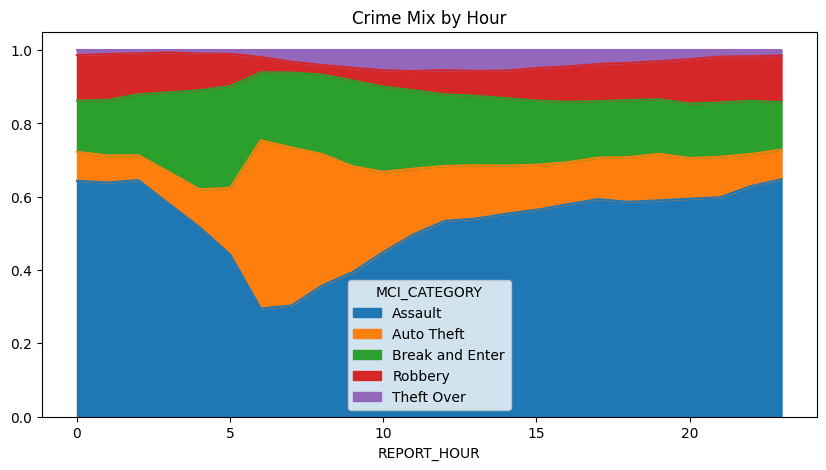

In [59]:
pd.crosstab(crime["REPORT_HOUR"], crime["MCI_CATEGORY"], normalize="index").plot(
    kind="area", figsize=(10,5), title="Crime Mix by Hour"
)


# 3. Spatial Sanity Check

Before analyzing transit-specific crime, we visualize all crime locations to ensure data quality:
- Verify crimes fall within Toronto's boundaries
- Identify spatial clusters or hotspots
- Detect any coordinate errors or outliers

This scatter plot provides a geographic overview of where crimes are concentrated across the city.

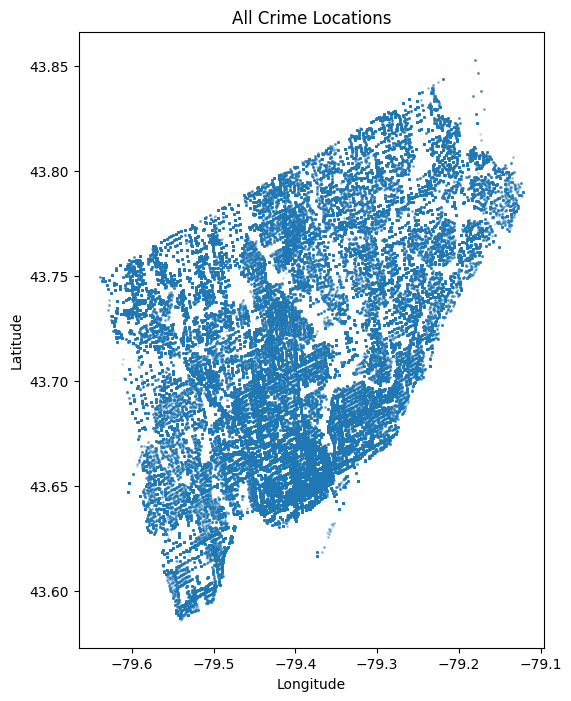

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,8))
plt.scatter(crime["LONG_WGS84"], crime["LAT_WGS84"], s=1, alpha=0.2)
plt.title("All Crime Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# 4. Load TTC Station Data

Load the station coordinates we extracted earlier and prepare them for spatial analysis. We assign station names based on the cluster index for now (could be replaced with actual station names from an external dataset).

In [ ]:
# Downloaded from
# https://data.urbandatacentre.ca/catalogue/city-toronto-ttc-subway-shapefiles?utm_source=chatgpt.com
stations = pd.read_csv("/Users/vicky_ceshen/Downloads/ttc_station_coords.csv")
stations["station_name"] = stations.index.astype(str)

stations = stations.rename(columns={
    "station_lat": "LAT",
    "station_lon": "LON"
})


In [69]:
stations.head()

,LAT,LON,station_name
0,43.789584,-79.526064,0
1,43.780830,-79.520838,1
2,43.771957,-79.494975,2
3,43.766629,-79.491881,3
4,43.754762,-79.485712,4


# 5. Distance to Nearest Station

Calculate the distance from each crime location to the nearest TTC station using the **Haversine formula**, which accounts for Earth's curvature.

**Method:**
1. Convert coordinates from degrees to radians
2. Build a BallTree spatial index for efficient nearest-neighbor search
3. Query the tree to find the closest station for each crime
4. Calculate great-circle distance in kilometers (Earth radius = 6371 km)

This enables us to identify "transit-proximate" crimes that occur within walking distance of stations.

In [62]:
from sklearn.neighbors import BallTree

# Convert to radians
crime_coords = np.deg2rad(crime[["LAT_WGS84","LONG_WGS84"]])
station_coords = np.deg2rad(stations[["LAT","LON"]])

tree = BallTree(station_coords, metric="haversine")

dist, idx = tree.query(crime_coords, k=1)

crime["nearest_station"] = stations.iloc[idx.flatten()]["station_name"].values
crime["dist_to_station_km"] = dist.flatten() * 6371  # Earth radius


# 6. Define Transit-Relevant Crimes

Create binary flags to identify crimes within typical walking distances of transit stations:
- **500m** (~5-7 minute walk): Immediate station area, likely transit users
- **1km** (~12-15 minute walk): Extended catchment area

We calculate what percentage of all crimes fall within these radii, which helps quantify the scope of transit-related public safety concerns.

In [ ]:
crime["within_500m"] = crime["dist_to_station_km"] <= 0.5
crime["within_1km"] = crime["dist_to_station_km"] <= 1.0

crime["within_500m"].mean()
""

np.float64(0.13058715707342433)

# 7. Crime Counts by Station

Rank stations by the total number of crimes occurring within 500m. This identifies the **highest-risk stations** where increased police presence or security measures may be warranted.

**Note:** Raw counts don't account for ridership exposure—busy stations naturally have more crimes. Section 8 addresses this by normalizing for ridership.

In [64]:
station_risk = (
    crime[crime["within_500m"]]
    .groupby("nearest_station")
    .size()
    .sort_values(ascending=False)
)

station_risk.head(10)


nearest_station
13    7131
12    5192
14    4700
20    2669
11    2404
46    1931
28    1929
29    1645
19    1640
21    1510
dtype: int64

# 8. Risk-Adjusted Analysis: Crime Rate per Ridership - To be changed

To fairly compare station safety, we need to adjust for **exposure** (ridership volume). Stations with high ridership naturally have more crimes due to more people.

**Crime Rate Calculation:**
- Crime per 10,000 daily riders = (Crime count / Daily riders) × 10,000

This reveals which stations are disproportionately dangerous relative to their usage, helping prioritize safety interventions.

**Note:** This section requires external ridership data. If unavailable, skip to section 9.

since the stations data above is by index, needs to translate into station name before join

In [ ]:
# Downloaded from https://cdn.ttc.ca/-/media/Project/TTC/DevProto/Documents/Home/Transparency-and-accountability/Subway-Ridership-20232024.pdf?rev=4424b4bf53e443bd85031beab56649b7
ridership = pd.read_csv("/Users/vicky_ceshen/Documents/ttc_station_ridership.csv")
stations = stations.merge(ridership, on="station_name", how="left")


KeyError: 'station_name'

# 9. Event Shock Detection: Crime Near Major Venues

Large events (sports games, concerts) can cause temporary spikes in transit-area crime. This analysis:
1. Identifies crimes near major venues (Rogers Centre, Scotiabank Arena, etc.)
2. Compares hourly crime patterns near venues vs. baseline
3. Detects "event shock" effects during typical event hours (evening/night)

This helps transit police anticipate and prepare for event-day surges in crowd-related incidents.

**Note:** Requires event venue location data. Mark as "To be added later" if data is unavailable.

In [ ]:
venues = pd.read_csv("event_venues.csv")
# venue_name, LAT, LON
venue_coords = np.deg2rad(venues[["LAT","LON"]])
venue_tree = BallTree(venue_coords, metric="haversine")

dist, idx = venue_tree.query(crime_coords, k=1)

crime["dist_to_venue_km"] = dist.flatten() * 6371
crime["near_venue"] = crime["dist_to_venue_km"] <= 1.0
crime["venue"] = venues.iloc[idx.flatten()]["venue_name"].values

# crowd shock effects
crime[crime["near_venue"]].groupby("REPORT_HOUR").size()
crime[~crime["near_venue"]].groupby("REPORT_HOUR").size()

